In [26]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [29]:
train_dir = 'C:\\Learning resource\\MCS PROJECT\\data\\ferdb_train\\'
test_dir = 'C:\\Learning resource\\MCS PROJECT\\data\\ferdb_test\\'

row, col = 256, 256
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   7336     6857  5936   5864     5552  6102      6970
      angry  disgust  fear  happy  neutral   sad  surprise
test   1833     1714  1483   1466     1387  1525      1742


<AxesSubplot:>

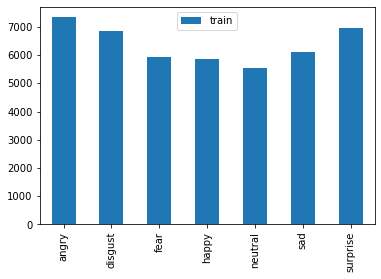

In [30]:
train_count.transpose().plot(kind='bar')

<AxesSubplot:>

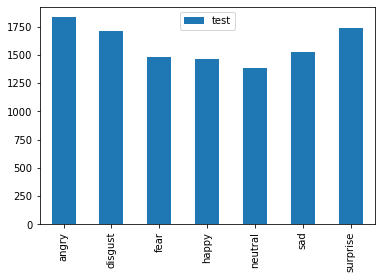

In [31]:
test_count.transpose().plot(kind='bar')

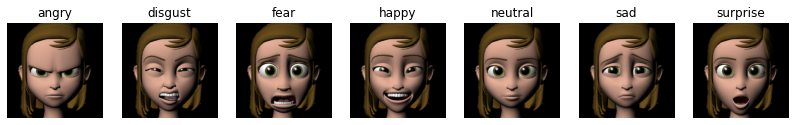

In [32]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [33]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=256,
                                                target_size=(256,256),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=256,
                                                target_size=(256,256),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 44617 images belonging to 7 classes.
Found 11150 images belonging to 7 classes.


In [20]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [38]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [39]:
fernet = get_model((row,col,1), classes)
fernet.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[2032128,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [31]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [24]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [25]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
174/174 [==============================] - ETA: 0s - loss: 4.1824 - accuracy: 0.4426

UnknownError: 2 root error(s) found.
  (0) Unknown:  UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000002653693D5E0>
Traceback (most recent call last):

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\script_ops.py", line 249, in __call__
    ret = func(*args)

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 892, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\keras\engine\data_adapter.py", line 822, in wrapped_generator
    for data in generator_fn():

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\keras\engine\data_adapter.py", line 948, in generator_fn
    yield x[i]

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\keras_preprocessing\image\iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\keras_preprocessing\image\iterator.py", line 227, in _get_batches_of_transformed_samples
    img = load_img(filepaths[j],

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\keras_preprocessing\image\utils.py", line 114, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\PIL\Image.py", line 3030, in open
    raise UnidentifiedImageError(

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000002653693D5E0>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
  (1) Unknown:  UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000002653693D5E0>
Traceback (most recent call last):

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\script_ops.py", line 249, in __call__
    ret = func(*args)

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 892, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\keras\engine\data_adapter.py", line 822, in wrapped_generator
    for data in generator_fn():

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\keras\engine\data_adapter.py", line 948, in generator_fn
    yield x[i]

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\keras_preprocessing\image\iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\keras_preprocessing\image\iterator.py", line 227, in _get_batches_of_transformed_samples
    img = load_img(filepaths[j],

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\keras_preprocessing\image\utils.py", line 114, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "C:\TOOL\anaconda\envs\tensorflow\lib\site-packages\PIL\Image.py", line 3030, in open
    raise UnidentifiedImageError(

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000002653693D5E0>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_6666]

Function call stack:
test_function -> test_function


In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
fernet.save_weights('fernet_bestweight.h5')

In [ ]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)